In [1]:
%matplotlib notebook
from labdaq import *

import pylab as plt

pref = default_preferences
task = IOTask(pref['channels'],pref['channel_modes'])
task.task_ao.write([0,0,0],auto_start=True)


1

<IPython.core.display.Javascript object>


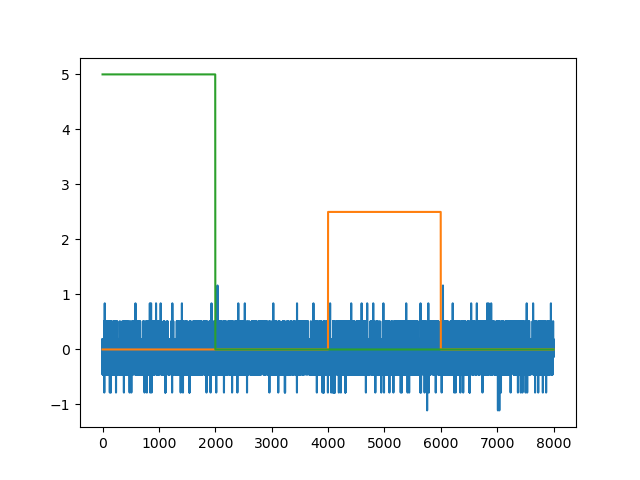

In [2]:
import socket

blueoff_time = .1
blueon_time = .1
redon_time = .1
ntrials = 10
opto = stimgen_waveform([[blueoff_time,1,0,0,0,0,0,0,0,0],
                         [blueon_time,1,0,0,0,0,0,0,0,0],
                         [redon_time,1,2.5,0,0,0,0,0,0,0],
                         [blueon_time,1,0,0,0,0,0,0,0,0]])
gate = stimgen_waveform([[blueoff_time,1,5,0,0,0,0,0,0,0],
                         [blueon_time,1,0,0,0,0,0,0,0,0],
                         [redon_time,1,0,0,0,0,0,0,0,0],
                         [blueon_time,1,0,0,0,0,0,0,0,0]])

# labcams = socket.socket()
fig = plt.figure()
iti = 1
tstart = 0
for i in range(1):
    task.load([None,opto,gate])
    values= task.run()
    fig.clf()
    plt.plot(np.vstack([values,opto,gate]).T)
    fig.canvas.draw()
    time.sleep(iti)
    

In [ ]:
task.run(blocking=False)
time.sleep(1)
print(self.data)

<IPython.core.display.Javascript object>


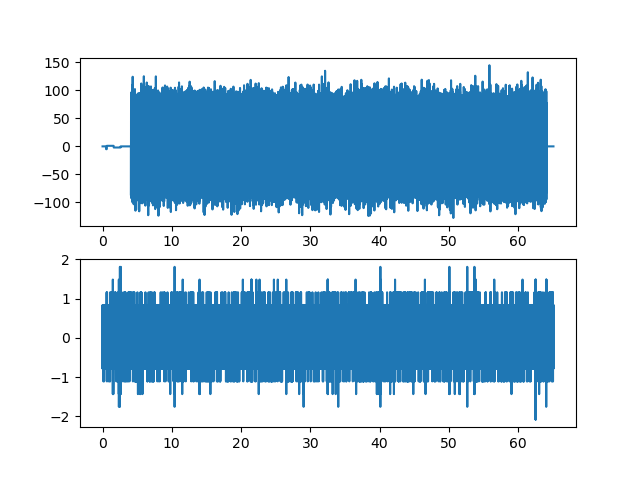

In [4]:
x = stimgen_waveform([[.5,1,0,10,1,0,0,0,0,0],
                          [0.1,1,-5,0,0,0,0,0,0,0],
                          [1,1,1,0,0,0,0,0,0,0],
                          [1,1,-2,0,0,0,0,0,0,0],
                          [1.5,1,0,10,0,0,0,0,0,0],
                          [60,2,0,20,0,0,0,0,0,0],
                          [1,1,0,0,1,0,0,0,0,0]])
task.load([x])
time.sleep(1)
values= task.run()

fig = plt.figure()
fig.add_subplot(2,1,1)
t = np.arange(len(x))/task.srate
plt.plot(t,x)
fig.add_subplot(2,1,2)
plt.plot(t,values.flatten())

In [8]:
blueoff_time = 0.1
blueon_time = 0.1
opto = stimgen_waveform([[blueoff_time,1,0,0,0,0,0,0,0,0],
                         [blueon_time,1,0,0,0,0,0,0,0,0],
                         [1000,1,2.5,0,0,0,0,0,0,0],
                         [blueon_time,1,0,0,0,0,0,0,0,0]])

task.task_do.write(opto!=0,auto_start=True)

20006000

<IPython.core.display.Javascript object>


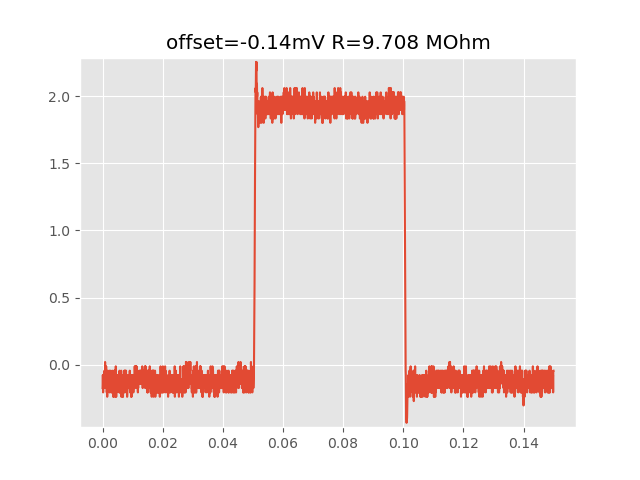

In [3]:
plt.figure()
anim = nb_seal_test(task,amp=[10,200])


<IPython.core.display.Javascript object>


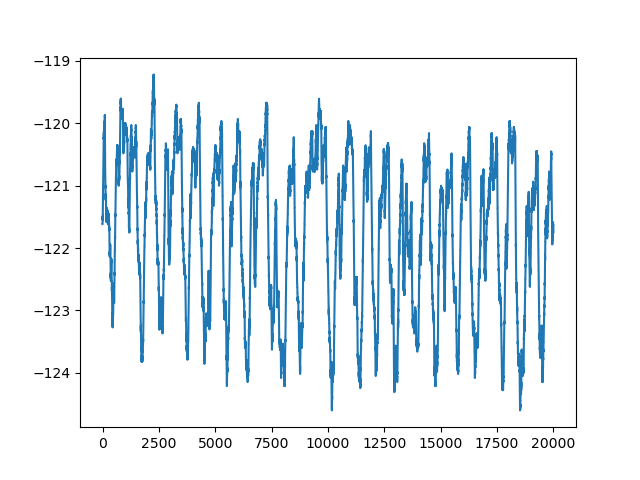

In [3]:
task.load([np.zeros(int(1*task.srate))])
val = task.run()
plt.figure()
plt.plot(val)

In [5]:
task.task_ao.timing.samp_clk_src


'/Dev2/ao/SampleClockTimebase'

In [9]:
task.close()

<IPython.core.display.Javascript object>


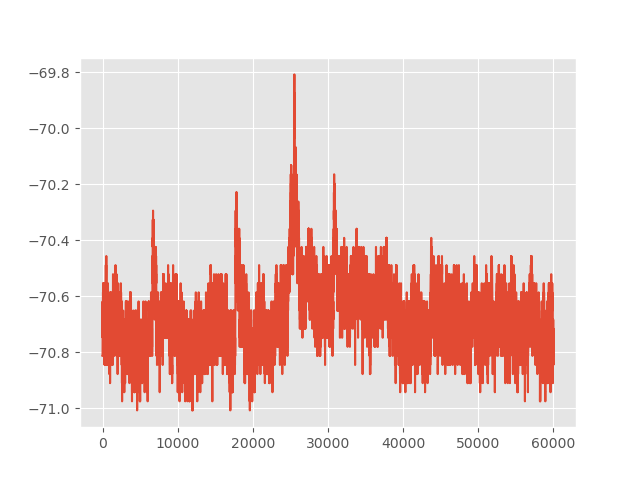

In [3]:
import pylab as plt
plt.matplotlib.style.use('ggplot')

plt.figure()
for amplitude in [50]:
    srate = task.srate
    pulse = [np.hstack([np.zeros(int(1*srate)),amplitude*np.ones(int(1*srate)),np.zeros(int(1*srate))])]
    time = np.arange(len(pulse))/srate
    task.load(pulse)
    values= task.run()
    plt.plot(values)

In [1]:

import nidaqmx
%matplotlib notebook
import pylab as plt
import numpy as np

import time
class Task():
    def __init__(self, aichan = 'Dev2/ai0', 
                 aochan='Dev2/ao0',
                 modechan='Dev2/ai1',
                 aiconversion=[1000,100],
                 aoconversion = [0.05,0.00005],
                 srate = 20000):
        # init tasks
        self.task_ai = None
        self.task_ao = None
        self.task_di = None
        self.task_do = None
        self.srate = srate
        self.aoconversion = np.float32(aoconversion)
        self.aiconversion = np.float32(aiconversion)
        if not aichan is None:
            self.task_ai = nidaqmx.Task()
            self.task_ai.ai_channels.add_ai_voltage_chan(aichan)
            #elf.task_ai.triggers.sync_type.MASTER = True
            #elf.task_ai.control(nidaqmx.constants.TaskMode.TASK_COMMIT)
        if not aochan is None:
            self.task_ao = nidaqmx.Task()
            #f not self.task_ai is None:
            #   self.task_ao.triggers.sync_type.SLAVE = True
            self.task_ao.ao_channels.add_ao_voltage_chan(aochan)
        if not modechan is None:
            self.task_mode = nidaqmx.Task()
            self.task_mode.ai_channels.add_ai_voltage_chan(modechan)
        self.mode = None
        self._check_mode()
    def load(self,stim):
        self._check_mode()
        if self.mode in ['IC','IC=0']:
            aoconversion = self.aoconversion[1]
            print('in cclamp')
        else:
            aoconversion = self.aoconversion[0]
        self.nsamples = max(stim.shape)
        if not self.task_ai is None:
            self.task_ai.timing.cfg_samp_clk_timing(rate = self.srate,
                                                    samps_per_chan = self.nsamples)
        if not self.task_ao is None:
            self.task_ao.timing.cfg_samp_clk_timing(rate = self.srate,
                                                    samps_per_chan = self.nsamples)
            self.task_ao.write((stim*aoconversion).astype(np.float32), auto_start=False)
    
    def _check_mode(self):
        if not hasattr(self,'task_mode'):
            return None
        mm = int(np.round(self.task_mode.read()))
        if mm in [2,1,4]:
            self.mode = 'IC'
        elif mm == 3:
            self.mode = 'IC=0'
        elif mm in [4,5]:
            self.mode = 'VC'
        else:
            self.mode = None
    def run(self):
        self._check_mode()
        if self.mode in ['IC','IC=0']:
            aiconversion = self.aiconversion[1]
        else:
            aiconversion = self.aiconversion[0]
        self.task_ai.start()
        self.task_ao.start()
        data=self.task_ai.read(number_of_samples_per_channel = nidaqmx.constants. READ_ALL_AVAILABLE)
        self.task_ai.stop()
        self.task_ao.stop()
        return np.array(data)*aiconversion
    
    def close(self):
        self.task_ai.close()
        self.task_ao.close()
task = Task()

# with  as task:
#     task.ao_channels.add_ao_voltage_chan('Dev2/ao0')
#     task.timing.cfg_samp_clk_timing(srate)
#     print('1 Channel N Samples Write: ')
#     print(task.write(pulse.astype(np.float32), auto_start=True))
#     time.sleep(1)
#     task.stop()
    

In [5]:
plt.savefig('C:/Users/tony/Desktop/myfirstcell_01.pdf')

